<a href="https://colab.research.google.com/github/xhxuciedu/CS284A/blob/master/TF_motif_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting TF Binding Sites

Transcription Factors (TFs) are proteins that bind to the DNA and help regulate gene transcription. The TFs have to recognize some "motif" on the DNA upstream from the gene, and DNA accessibility also plays a role.  

In tis problem set, we will develop ML methods to predict which sequences can be bound by a transcription factor called JUND.  The binding profile of JUND expressed in terms of a sequence logo is shown in the following image.

In [37]:
# get the image
Image(url="https://www.ismara.unibas.ch/ISMARA/scratch/NHBE_SC2/ismara_report/logos/JUND.png", width=350, height=300)


## MLP model 

In this assignment you'll modify write an MLP model the predict whether a segments of the human chromosome 22 (Chr22) contain the binding sites for the JUND TF. You can modify the mlp notebook I shared with you to work on this problem. You need to have at least one hidden layer. You have to compute a weighted loss, and include accessibility information in your model, as described below.



## Dataset
The data comprises 101 length segments from Chr22, with each position a one-hot vector denoting one of the four bases (A, C, G, T). Thus, each element of the input is 2d with size 101×4101×4. Each such element has a target label 00 or 11, indicating whether the TF binds to that segment or not. The data also includes a weight per input element, since there are only a few binding sites (0.42%), so that you'd obtain an accuracy of 99.58% just by predicting there are no binding sites. This means you have to use the weights to discount the losses for label 00 and enhance the losses for label 11 items. Finally, there is an array of values, one per input element, that also indicates the chromosome accessibility for that segment.

The data is split into training, validation and testing sets. Each set contains the following files:

shard-0-X.joblib: the set of 101 x 4 input elements
shard-0-y.joblib: the true labels: 0 or 1
shard-0-w.joblib: weight per input element
shard-0-a.joblib: accessibility value per input element
You can read these files by using joblib.load function, which will populate a numpy array. For example

Data Credit: Mohammed Zaki

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Check GPU availability

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
!unzip TF_data.zip

Archive:  TF_data.zip
   creating: train_dataset/
 extracting: train_dataset/metadata.csv.gzip  
  inflating: train_dataset/shard-0-a.joblib  
  inflating: train_dataset/shard-0-ids.joblib  
  inflating: train_dataset/shard-0-w.joblib  
  inflating: train_dataset/shard-0-X.joblib  
  inflating: train_dataset/shard-0-y.joblib  
 extracting: train_dataset/tasks.json  
   creating: valid_dataset/
 extracting: valid_dataset/metadata.csv.gzip  
  inflating: valid_dataset/shard-0-a.joblib  
  inflating: valid_dataset/shard-0-ids.joblib  
  inflating: valid_dataset/shard-0-w.joblib  
  inflating: valid_dataset/shard-0-X.joblib  
  inflating: valid_dataset/shard-0-y.joblib  
 extracting: valid_dataset/tasks.json  
   creating: test_dataset/
 extracting: test_dataset/metadata.csv.gzip  
  inflating: test_dataset/shard-0-a.joblib  
  inflating: test_dataset/shard-0-ids.joblib  
  inflating: test_dataset/shard-0-w.joblib  
  inflating: test_dataset/shard-0-X.joblib  
  inflating: test_dataset/sha

In [6]:
!ls

sample_data  test_dataset  TF_data.zip	train_dataset  valid_dataset


In [7]:
import joblib

In [24]:
from torch.utils.data import Dataset

class JUND_Dataset(Dataset):
    def __init__(self, data_dir):
        '''load X, y, w, a from data_dir'''        
        super(JUND_Dataset, self).__init__()

        # load X, y, w, a from given data_dir
        # convert them into torch tensors
        self.X = torch.from_numpy(joblib.load(data_dir + '/shard-0-X.joblib'))
        self.y = torch.from_numpy(joblib.load(data_dir + '/shard-0-y.joblib'))
        self.w = torch.from_numpy(joblib.load(data_dir + '/shard-0-w.joblib'))
        self.a = torch.from_numpy(joblib.load(data_dir + '/shard-0-a.joblib'))

    def __len__(self):
        '''return len of dataset'''
        return self.X.shape[0]

    def __getitem__(self, idx):
        '''return X, y, w, and a values at index idx'''
        return self.X[idx],self.y[idx],self.w[idx], self.a[idx]

In [31]:
train_dataset = JUND_Dataset('train_dataset')

In [32]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [33]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
train_loader

### Hyper parameters

### Traing and test data

In [ ]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

Processing...
Done!


In [ ]:
print('Train data: ', train_dataset.train_data.shape)
print('Test data: ', test_dataset.test_data.shape)

Train data:  torch.Size([60000, 28, 28])
Test data:  torch.Size([10000, 28, 28])


### Check data

In [34]:
X,y,w,a = next(iter(train_loader))

In [36]:
X.shape, y.shape, w.shape, a.shape

(torch.Size([100, 101, 4]),
 torch.Size([100, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

In [ ]:
print(images.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


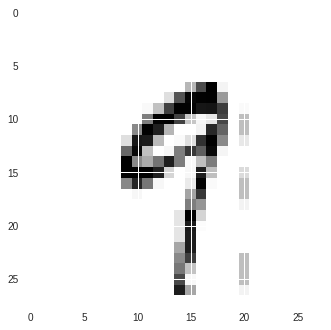

In [ ]:
plt.imshow(images[0,0,:,:])

### Defining the model

In [ ]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


### Check parameters of the model

In [ ]:
print(model.layer1.parameters)

<bound method Module.parameters of Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)>


In [ ]:
# Check the convolution parameters
list(model.layer1.parameters())[0].shape

torch.Size([16, 1, 5, 5])

### Training

In [ ]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/600], Loss: 0.1433
Epoch [1/5], Step [200/600], Loss: 0.0854
Epoch [1/5], Step [300/600], Loss: 0.0747
Epoch [1/5], Step [400/600], Loss: 0.0847
Epoch [1/5], Step [500/600], Loss: 0.0234
Epoch [1/5], Step [600/600], Loss: 0.1008
Epoch [2/5], Step [100/600], Loss: 0.1024
Epoch [2/5], Step [200/600], Loss: 0.0219
Epoch [2/5], Step [300/600], Loss: 0.0414
Epoch [2/5], Step [400/600], Loss: 0.1012
Epoch [2/5], Step [500/600], Loss: 0.0060
Epoch [2/5], Step [600/600], Loss: 0.0359
Epoch [3/5], Step [100/600], Loss: 0.0024
Epoch [3/5], Step [200/600], Loss: 0.0200
Epoch [3/5], Step [300/600], Loss: 0.0192
Epoch [3/5], Step [400/600], Loss: 0.0235
Epoch [3/5], Step [500/600], Loss: 0.0198
Epoch [3/5], Step [600/600], Loss: 0.0158
Epoch [4/5], Step [100/600], Loss: 0.0414
Epoch [4/5], Step [200/600], Loss: 0.1056
Epoch [4/5], Step [300/600], Loss: 0.0126
Epoch [4/5], Step [400/600], Loss: 0.0657
Epoch [4/5], Step [500/600], Loss: 0.0350
Epoch [4/5], Step [600/600], Loss:

### Testing

In [ ]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 10000 test images: 99.09 %


In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')